In [1]:
import requests
import pandas as pd

import json

## Carregar dados de exportação 2023 para comparar com dados de produção

In [2]:
exportacoes_mundo_2023 = pd.read_excel('./dados/comex/Exportação  Mundo 2023 NCM.xlsx')
exportacoes_usa_2023 = pd.read_excel('./dados/comex/Exportação USA 2023 NCM.xlsx.xlsx')


### Preparar dados

### Corrigir NCM's inserindo zeros à esquerda

In [3]:
exportacoes_mundo_2023['cod_ncm'] = exportacoes_mundo_2023['Código NCM'].astype(str).str.zfill(8)
exportacoes_usa_2023['cod_ncm'] = exportacoes_usa_2023['Código NCM'].astype(str).str.zfill(8)

### Aplicar a taxa de câmbio média

In [4]:
#Taxa média de câmbio em 2023 - compra
taxa_cambio = 5.39  # Exemplo de taxa média de câmbio em 2023
exportacoes_mundo_2023['R$ FOB Mundo'] = exportacoes_mundo_2023['2023 - Valor US$ FOB'] * taxa_cambio
exportacoes_usa_2023['R$ FOB USA'] = exportacoes_usa_2023['2023 - Valor US$ FOB'] * taxa_cambio

#### Agregar por SH6

In [5]:
exportacoes_mundo_2023['SH6'] = exportacoes_mundo_2023['cod_ncm'].str[0:6]
exportacoes_usa_2023['SH6'] = exportacoes_usa_2023['cod_ncm'].str[0:6]

#Agregar os valores por SH6
exportacoes_mundo_2023 = exportacoes_mundo_2023.groupby('SH6')[['R$ FOB Mundo']].sum()
    

In [6]:
exportacoes_usa_2023 = exportacoes_usa_2023.groupby('SH6')[['R$ FOB USA']].sum()    

In [7]:
exportacoes = exportacoes_mundo_2023.merge(exportacoes_usa_2023, on='SH6', how='left').fillna(0)

In [8]:
exportacoes['participacao_usa'] = exportacoes['R$ FOB USA'] / (exportacoes['R$ FOB Mundo'])

In [9]:
exportacoes.head(2)

,R$ FOB Mundo,R$ FOB USA,participacao_usa
SH6,,,
010121,40075081.20,29427610.52,0.734312
010129,21803972.96,15256136.28,0.699695


In [10]:
exportacoes_mundo_2023.head(2)

,R$ FOB Mundo
SH6,
010121,40075081.20
010129,21803972.96


## Mapeamento ISIC e CNAE

### Carregar tabelas do comexstat de ISIC e NCM/SH para o mapeamento com ISIC

In [11]:
ncm_isic = pd.read_csv('./dados/comex/NCM_ISIC (1).csv',sep=';',dtype={'CO_ISIC_CLASSE': str, 'NO_ISIC_CLASSE': str}    )
ncm = pd.read_csv('./dados/comex/NCM (2).csv',sep=';',dtype={'CO_SH6': str, 'CO_ISIC_CLASSE': str})

### Carregar a tabela de mapeamento de ISIC para CNAE do IBGE

In [12]:
mapeamento_isic = pd.read_excel('./dados/mapeamento/mapeamento_isic_cnae.xlsx', dtype=str).drop(columns=['Unnamed: 3','Observações'])

##### Fazer a primeira tentativa usando códigos ISIC a 3 dígitos

In [13]:
mapeamento_isic = mapeamento_isic[mapeamento_isic['código ISIC'].str.len() == 3]
mapeamento_isic.tail()

,código ISIC,denominação ISIC,código CNAE,denominação CNAE
1171,960,Otras actividades de servicios personales,96.0,Outras atividades de serviços pessoais
1178,970,Actividades de los hogares como empleadores de...,97.0,Serviços domésticos
1181,981,Actividades no diferenciadas de los hogares co...,NaN,NaN
1183,982,Actividades no diferenciadas de los hogares co...,NaN,NaN
1187,990,Actividades de organizaciones y órganos extrat...,99.0,Organismos internacionais e outras instituiçõe...


#### Eliminar códigos ISIC sem correspondência

In [14]:
mapeamento_isic = mapeamento_isic.dropna()

In [15]:
mapeamento_isic['CNAE2d'] = mapeamento_isic['código CNAE'].str[0:2]
mapeamento_isic['ISIC2d'] = mapeamento_isic['código ISIC'].str[0:2]

#### Verificar se há códigos ISIC a dois dígitos que correspondem a mais de uma cnae a dois dígitos

In [16]:
mapeamento_isic.groupby('ISIC2d')[['CNAE2d']].nunique().sort_values(by='CNAE2d', ascending=False).head(10)

,CNAE2d
ISIC2d,
19,2
22,2
16,2
20,2
88,2
70,2
58,2
08,1
07,1


In [17]:
mapeamento_isic.query('ISIC2d.isin(["58","70","88"])')

,código ISIC,denominação ISIC,código CNAE,denominação CNAE,CNAE2d,ISIC2d
822,581,Edición de libros y publicaciones periódicas y...,58.1,"Edição de livros, jornais, revistas e outras a...",58,58
823,581,Edición de libros y publicaciones periódicas y...,58.2,"Edição integrada à impressão de livros, jornai...",58,58
834,582,Edición de programas informáticos,62.0,Atividades dos serviços de tecnologia da infor...,62,58
955,701,Actividades de oficinas principales,64.6,Atividades de sociedades de participação,64,70
956,701,Actividades de oficinas principales,70.1,Sedes de empresas e unidades administrativas l...,70,70
960,702,Actividades de consultoría de gestión,70.2,Atividades de consultoria em gestão empresarial,70,70
1117,881,Actividades de asistencia social sin alojamien...,88.0,Serviços de assistência social sem alojamento,88,88
1119,889,Otras actividades de aistencia social sin aloj...,85.1,Educação infantil e ensino fundamental,85,88
1120,889,Otros servicios sociales sin alojamiento n.c.p.,88.0,Serviços de assistência social sem alojamento,88,88


#### Códigos a 2 dígitos ISIC que estão relacionados a mais de um código CNAE a 2 dígitos sempre estão vinculados a dígitos idênticos mais um outro. Nesses casos, se considerará apenas os dois dígitos idênticos, descartando o segundo

In [18]:
mapeamento_isic.query('`CNAE2d`.isin(["15"])')

,código ISIC,denominação ISIC,código CNAE,denominação CNAE,CNAE2d,ISIC2d
213,151,Curtido y adobo de cueros; fabricación de male...,15.1,Curtimento e outras preparações de couro,15,15
214,151,Curtido y adobo de cueros; fabricación de male...,15.2,Fabricação de artigos para viagem e de artefat...,15,15
218,152,Fabricación de calzado,15.3,Fabricação de calçados,15,15
219,152,Fabricación de calzado,15.4,"Fabricação de partes para calçados, de qualque...",15,15
229,162,"Fabricación de productos de madera, corcho, pa...",15.4,"Fabricação de partes para calçados, de qualque...",15,16
315,221,Fabricación de productos de caucho,15.4,"Fabricação de partes para calçados, de qualque...",15,22
321,222,Fabricación de productos de plástico,15.4,"Fabricação de partes para calçados, de qualque...",15,22


Decidiu-se por usar os dois primeiros dígitos do ISIC como aproximação da CNAE, quando a correspondência a 3 dígitos não é possível, por haver mapeamento a mais de uma CNAE vinculadao ao código ISIC a 3 dígitos. Ver seção de mapeamento ISIC x CNAE x PIA

Remover mapeamentos CNAE ISIC para códigos com os dois primeiros dígitos divergentes.

In [19]:
mapeamento_isic = mapeamento_isic.query('CNAE2d == ISIC2d')

### Remover exportações com valor 0 e mapear exportações com código ISIC a 4 dígitos

In [20]:
exportacoes = exportacoes.query('`R$ FOB USA` > 0')

In [21]:
exportacoes = ncm[['CO_SH6','CO_ISIC_CLASSE']].drop_duplicates().merge(exportacoes, left_on='CO_SH6', right_on='SH6', how='inner')

## Carregar dados da PIA Empresa

In [22]:
url_pia_empresa = 'https://apisidra.ibge.gov.br/values/t/1842/n1/all/v/824,825/p/last%201/c12762/all'

data = requests.get(url_pia_empresa)
data = data.json()
pia_empresa_rlv = pd.DataFrame(data, columns=data[0])
pia_empresa_rlv.columns = pia_empresa_rlv.iloc[0]
pia_empresa_rlv = pia_empresa_rlv[1:]


### Preparar dados da PIA criando uma coluna de CNAE com resultados da receita líquida de vendas a 2 e a 3 dígitos, para serem mapeados para as NCM's abaixo.

In [23]:
##Filtrar apenas registros cujos valores da coluna 'Classificação Nacional de Atividades Econômicas (CNAE 2.0)' siga o padrão \d{2}\.\d{1} 
pia_empresa_rlv_2d = pia_empresa_rlv[pia_empresa_rlv['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str.match(r'^\d{2} ')]
pia_empresa_rlv_3d = pia_empresa_rlv[pia_empresa_rlv['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str.match(r'^\d{2}\.\d{1} ')]    

pia_empresa_rlv_2d.loc[:,'cnae'] = pia_empresa_rlv_2d.loc[:,'Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[0:2].str.replace('.','', regex=False)
pia_empresa_rlv_2d.loc[:,'cnae_descricao'] = pia_empresa_rlv_2d.loc[:,'Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[3:]


/tmp/ipykernel_15162/3448316682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pia_empresa_rlv_2d.loc[:,'cnae'] = pia_empresa_rlv_2d.loc[:,'Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[0:2].str.replace('.','', regex=False)
/tmp/ipykernel_15162/3448316682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pia_empresa_rlv_2d.loc[:,'cnae_descricao'] = pia_empresa_rlv_2d.loc[:,'Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[3:]


In [24]:
pia_empresa_rlv_3d['cnae'] = pia_empresa_rlv_3d['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[0:4].str.replace('.','', regex=False)
pia_empresa_rlv_3d['cnae_descricao'] = pia_empresa_rlv_3d['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[5:]

/tmp/ipykernel_15162/1737546974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pia_empresa_rlv_3d['cnae'] = pia_empresa_rlv_3d['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[0:4].str.replace('.','', regex=False)
/tmp/ipykernel_15162/1737546974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pia_empresa_rlv_3d['cnae_descricao'] = pia_empresa_rlv_3d['Classificação Nacional de Atividades Econômicas (CNAE 2.0)'].str[5:]


In [25]:
pia_empresa_rlv = pd.concat([pia_empresa_rlv_2d[['Variável','cnae','cnae_descricao','Valor']], pia_empresa_rlv_3d[['Variável','cnae','cnae_descricao','Valor']]], ignore_index=True)

In [26]:
#Linhas em que o valor da coluna 'Valor' não pode ser convertido para float, trocar por -1
pia_empresa_rlv['Valor'] = pd.to_numeric(pia_empresa_rlv['Valor'], errors='coerce').fillna(-1)
pia_empresa_rlv['Valor'] = pia_empresa_rlv['Valor']*1000
#Fazer o pivot transformando a coluna 'Variável' em colunas e preenchendo com os valores da coluna 'Valor'
pia_empresa_rlv = pia_empresa_rlv.pivot_table(index=['cnae','cnae_descricao'], columns='Variável', values='Valor')
pia_empresa_rlv.reset_index(inplace=True)

### Fazer o mapeamento ISIC x CNAE x NCM

In [27]:
mapeamento_isic['cnae'] = mapeamento_isic['código CNAE'].str.replace('.','', regex=False)

In [28]:
exportacoes_pia = exportacoes.copy()

#### Verificar as situações em que um ISIC a 3 dígitos é mapeado para mais de uma CNAE

Se houver vinculação a mais de uma CNAE, usar o código ISIC a 2 dígitos, senão, usar os 3 dígitos para melhor a precisão dos dados de produção

In [29]:
lista_codigos_isic_mapeados_multiplas_cnae_3d = pia_empresa_rlv_3d[['cnae']].drop_duplicates().merge(mapeamento_isic, on='cnae', how='left').groupby('código ISIC')[['código CNAE']].nunique().reset_index().query("`código CNAE` > 1")['código ISIC'].unique().tolist()

In [30]:
#criar uma coluna 'cnae' em exportacoes_pia e fazer com que seu valor  seja igual aos 2 dígitos da coluna CO_ISIC_CLASSE, caso os 3 primeiros dígitos do código isic classe fizerem parte de lista_codigos_isic_mapeados_multiplas_cnae_3d
# caso contrário, usar None
exportacoes_pia['cnae'] = exportacoes_pia['CO_ISIC_CLASSE'].str[0:2].where(
    exportacoes_pia['CO_ISIC_CLASSE'].str[0:3].isin(lista_codigos_isic_mapeados_multiplas_cnae_3d),
    None
)

In [31]:
#Nos campos None em cnae, usar o valor da coluna CO_ISIC_CLASSE e mapear os 3 primeiros dígitos para o código CNAE usando como mapeamento o mapeamento_isic
mapeamento_isic_unico = mapeamento_isic.drop_duplicates(subset='código ISIC')

exportacoes_pia['cnae'] = exportacoes_pia['cnae'].fillna(
    exportacoes_pia['CO_ISIC_CLASSE'].str[0:3].map(
        mapeamento_isic_unico.set_index('código ISIC')['cnae']
    )
)

In [32]:
exportacoes_pia[['CO_SH6','CO_ISIC_CLASSE','cnae']].drop_duplicates().to_excel('./dados/comex/mapeamento_sh6_isic_cnae.xlsx', index=False)

In [70]:
exportacoes_pia.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,cnae
0,490110,5811,6.996258e+06,701988.21,0.100338,581
1,490191,5811,2.892376e+06,73713.64,0.025485,581
2,490199,5811,1.819830e+08,19922588.07,0.109475,581
3,521029,1312,4.218591e+05,9055.20,0.021465,13
4,521032,1312,7.247394e+05,7702.31,0.010628,13


## Fazer o merge entre produção e exportação

In [33]:
exportacoes_pia = exportacoes_pia.merge(pia_empresa_rlv, on='cnae', how='inner')

In [34]:
exportacoes_pia.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas
0,521029,1312,4.218591e+05,9055.20,0.021465,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10
1,521032,1312,7.247394e+05,7702.31,0.010628,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10
2,521039,1312,2.658725e+05,15604.05,0.058690,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10
3,521049,1312,1.742285e+06,36204.63,0.020780,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10
4,640411,1520,4.041184e+08,2587388.65,0.006403,15,Preparação de couros e fabricação de artefatos...,5.268440e+10,5.349885e+10


## Mapear CNAE's para intensidade tecnológica

In [35]:
#Criar uma coluna de 'Intensidade Tecnloógica' de acordo com a classificação de intensidade tecnológica da OCDE, mapeada por ISIC, onde a os primeiros dígitos ISIC (2 ou 3 ) podem ser mapeados de acordo com a tabela ISIC x Intensidade Tecnológica é:
# Alta Intensidade Tecnológica: 303, 21, 26,72, 582
# Média Alta Intensidade Tecnológica: 252, 325, 28, 20, 27, 302, 304, 309,62-63
# Média Intensidade Tecnológica: 22, 301, 32 ( com exceção de 325),23, 24, 33
# Média Baixa Intensidade Tecnológica: 10-12,13, 14, 15, 25 ( menos 252),16, 18 19, 31
# Baixa Intensidade Tecnológica: Demais
#Considere que o código ISIC tabela de mapeamento pode ter 2 ou 3 dígitos, que devem corresponder aos primeiros 2 ou 3 dígitos do código ISIC da coluna CO_ISIC_CLASSE, ou seja,
#mapeie inicialmente os códigos com 3 dígitos e em seguida os códigos com 2 dígitos, caso não tenha sido mapeado ainda.
mapeamento_3d = {
    '303': 'Alta Intensidade Tecnológica',
    '582': 'Alta Intensidade Tecnológica',

    '302': 'Média Alta Intensidade Tecnológica',
    '252': 'Média Alta Intensidade Tecnológica',
    '304': 'Média Alta Intensidade Tecnológica',
    '325': 'Média Alta Intensidade Tecnológica',
    '309': 'Média Alta Intensidade Tecnológica',

    '301': 'Média Intensidade Tecnológica',
    
    '581':'Média Baixa Intensidade Tecnológica'
}


# Mapear códigos de 2 dígitos
mapeamento_2d = {
    '21': 'Alta Intensidade Tecnológica',
    '26': 'Alta Intensidade Tecnológica',
    '72': 'Alta Intensidade Tecnológica',

    '29': 'Média Alta Intensidade Tecnológica',
    '28': 'Média Alta Intensidade Tecnológica',
    '20': 'Média Alta Intensidade Tecnológica',
    '27': 'Média Alta Intensidade Tecnológica',
    '62': 'Média Alta Intensidade Tecnológica',
    '63': 'Média Alta Intensidade Tecnológica',

    '22': 'Média Intensidade Tecnológica',
    '32': 'Média Intensidade Tecnológica',
    '23': 'Média Intensidade Tecnológica',
    '24': 'Média Intensidade Tecnológica',
    '25': 'Média Intensidade Tecnológica',
    '33': 'Média Intensidade Tecnológica',

    '10': 'Média Baixa Intensidade Tecnológica',
    '11': 'Média Baixa Intensidade Tecnológica',
    '12': 'Média Baixa Intensidade Tecnológica',
    '13': 'Média Baixa Intensidade Tecnológica',
    '14': 'Média Baixa Intensidade Tecnológica',
    '15': 'Média Baixa Intensidade Tecnológica',
    '16': 'Média Baixa Intensidade Tecnológica',
    '17': 'Média Baixa Intensidade Tecnológica',
    '18': 'Média Baixa Intensidade Tecnológica',
    '19': 'Média Baixa Intensidade Tecnológica',
    '31': 'Média Baixa Intensidade Tecnológica',
    #69 a 75 Média Baixa Intensidade Tecnológica
    '69': 'Média Baixa Intensidade Tecnológica',
    '70': 'Média Baixa Intensidade Tecnológica',
    '71': 'Média Baixa Intensidade Tecnológica',
    '73': 'Média Baixa Intensidade Tecnológica',
    '74': 'Média Baixa Intensidade Tecnológica',
    '75': 'Média Baixa Intensidade Tecnológica',
    '61' : 'Média Baixa Intensidade Tecnológica',
    #05 a 09 Média Baixa Intensidade Tecnológica
    '05': 'Média Baixa Intensidade Tecnológica',
    '06': 'Média Baixa Intensidade Tecnológica',
    '07': 'Média Baixa Intensidade Tecnológica',
    '08': 'Média Baixa Intensidade Tecnológica',
    '09': 'Média Baixa Intensidade Tecnológica'

}



In [36]:
# Aplicar mapeamento primeiro por 3 dígitos, depois por 2 dígitos
exportacoes_pia['Intensidade Tecnológica'] = exportacoes_pia['CO_ISIC_CLASSE'].str[0:3].map(mapeamento_3d)

# Para valores não mapeados (NaN), tentar mapear por 2 dígitos
mask_nao_mapeado = exportacoes_pia['Intensidade Tecnológica'].isna()
exportacoes_pia.loc[mask_nao_mapeado, 'Intensidade Tecnológica'] = exportacoes_pia.loc[mask_nao_mapeado, 'CO_ISIC_CLASSE'].str[0:2].map(mapeamento_2d)

# Exceção: 252 deve ser removido de '25' (que já foi mapeado como Média Alta)
#mask_252 = exportacao_pia['CO_ISIC_CLASSE'].str.startswith('252')
#exportacao_pia.loc[mask_252, 'Intensidade Tecnológica'] = 'Baixa Intensidade Tecnológica'

# Para códigos não mapeados, classificar como 'Baixa Intensidade Tecnológica'
exportacoes_pia['Intensidade Tecnológica'] = exportacoes_pia['Intensidade Tecnológica'].fillna('Baixa Intensidade Tecnológica')

In [37]:
exportacoes.shape

(3455, 5)

In [38]:
exportacoes_pia.shape

(3222, 10)

In [39]:
exportacoes_pia.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas,Intensidade Tecnológica
0,521029,1312,4.218591e+05,9055.20,0.021465,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica
1,521032,1312,7.247394e+05,7702.31,0.010628,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica
2,521039,1312,2.658725e+05,15604.05,0.058690,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica
3,521049,1312,1.742285e+06,36204.63,0.020780,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica
4,640411,1520,4.041184e+08,2587388.65,0.006403,15,Preparação de couros e fabricação de artefatos...,5.268440e+10,5.349885e+10,Média Baixa Intensidade Tecnológica


In [40]:
exportacoes_pia.to_excel('./Outputs/final/exportacao_pia_intensidade.xlsx', index=False)

## Mapear dados para as tarifas

In [78]:
tarifas = pd.read_excel('./dados/comex/NCM_SH6_Tarifas_semauto.xlsx')

In [79]:
tarifas['Articles of Civil Aircraft only'].fillna('',inplace=True)

/tmp/ipykernel_15162/2934317571.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tarifas['Articles of Civil Aircraft only'].fillna('',inplace=True)


In [80]:
tarifas['SH6'] = tarifas['SH6'].astype(str).str.zfill(6)

In [81]:
exportacoes_pia_tarifas = exportacoes_pia.merge(tarifas.rename(columns={"SH6":"CO_SH6"}),on='CO_SH6',how='left')

In [82]:
exportacoes_pia_tarifas.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas,Intensidade Tecnológica,Instrumento,Tarifa,Articles of Civil Aircraft only
0,521029,1312,4.218591e+05,9055.20,0.021465,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
1,521032,1312,7.247394e+05,7702.31,0.010628,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
2,521039,1312,2.658725e+05,15604.05,0.058690,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
3,521049,1312,1.742285e+06,36204.63,0.020780,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
4,640411,1520,4.041184e+08,2587388.65,0.006403,15,Preparação de couros e fabricação de artefatos...,5.268440e+10,5.349885e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,


In [83]:
exportacoes_pia_tarifas.columns

Index(['CO_SH6', 'CO_ISIC_CLASSE', 'R$ FOB Mundo', 'R$ FOB USA',
       'participacao_usa', 'cnae', 'cnae_descricao',
       'Receita líquida de vendas de produtos e serviços industriais',
       'Total da receita líquida de vendas', 'Intensidade Tecnológica',
       'Instrumento', 'Tarifa', 'Articles of Civil Aircraft only'],
      dtype='object')

## Preparar relatório com as tarifas

In [84]:
exportacoes_pia_tarifas.head()

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas,Intensidade Tecnológica,Instrumento,Tarifa,Articles of Civil Aircraft only
0,521029,1312,4.218591e+05,9055.20,0.021465,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
1,521032,1312,7.247394e+05,7702.31,0.010628,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
2,521039,1312,2.658725e+05,15604.05,0.058690,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
3,521049,1312,1.742285e+06,36204.63,0.020780,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
4,640411,1520,4.041184e+08,2587388.65,0.006403,15,Preparação de couros e fabricação de artefatos...,5.268440e+10,5.349885e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,


In [85]:
exportacoes_pia_tarifas[exportacoes_pia_tarifas['cnae'] == '304'].head(2)

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas,Intensidade Tecnológica,Instrumento,Tarifa,Articles of Civil Aircraft only
353,880260,3030,10906142.17,5033871.92,0.461563,304,Fabricação de aeronaves,2.077463e+10,2.113848e+10,Alta Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,
496,840710,3030,21425638.08,17376788.66,0.811028,304,Fabricação de aeronaves,2.077463e+10,2.113848e+10,Alta Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,*


### Carregar label's dos códigos SH6

In [86]:
ncm_sh6 = pd.read_csv('./dados/comex/NCM_SH.csv', sep=';', dtype={'CO_SH6': str, 'CO_ISIC_CLASSE': str})
ncm_sh6 = ncm_sh6[['CO_SH6','NO_SH6_POR']]

In [87]:
exportacoes_pia_tarifas = exportacoes_pia_tarifas.merge(ncm_sh6, left_on='CO_SH6', right_on='CO_SH6', how='left')

In [88]:
exportacoes_pia_tarifas.head(2)

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas,Intensidade Tecnológica,Instrumento,Tarifa,Articles of Civil Aircraft only,NO_SH6_POR
0,521029,1312,421859.13,9055.20,0.021465,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,,"Outros tecidos de algodão branqueados, com fib..."
1,521032,1312,724739.40,7702.31,0.010628,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,,"Tecido de algodão tinto, em ponto sarjado, com..."


## Carregar dados de exportações por estados

In [89]:
exportacao_mundo_estados = pd.read_excel('./dados/comex/Exportacao_mundo_estados_2024.xlsx', dtype={'UF do Produto': str, 'Código SH6': str})

In [90]:
exportacao_eua_estados = pd.read_excel('./dados/comex/Exportacao_eua_estados_2024.xlsx', dtype={'UF do Produto': str, 'Código SH6': str})

In [91]:
exportacao_eua_estados = exportacao_eua_estados[['UF do Produto', 'Código SH6','2024 - Valor US$ FOB']].rename(columns={'2024 - Valor US$ FOB': 'Exportacao EUA'}).merge(exportacao_mundo_estados.rename(columns={'2024 - Valor US$ FOB': 'Exportacao Mundo'}), on=['UF do Produto', 'Código SH6'], how='right').fillna(0)

In [92]:
exportacao_eua_estados['Participacao EUA'] = exportacao_eua_estados['Exportacao EUA'] / exportacao_eua_estados['Exportacao Mundo']

In [102]:
exportacao_eua_estados.sort_values(by='Participacao EUA', ascending=False).head(2)

,UF do Produto,Código SH6,Exportacao EUA,Descrição SH6,Exportacao Mundo,Participacao EUA,SH6,Instrumento,Tarifa,Articles of Civil Aircraft only,Exportacao EUA Acumulada
35020,Rio de Janeiro,382590,1.0,Outros produtos residuais das indústrias quími...,1,1.0,382590,Ordem 30/07,Tarifa de 50%,,7.412874e+09
11671,Rondônia,482369,55377.0,"Bandejas, travessas, pratos, xícaras ou cháven...",55377,1.0,482369,Ordem 30/07,Tarifa de 50%,,1.225355e+08


In [ ]:
#Calcular a exportacao acumulada por UF do Produto, de forma que os valores sejam ordenados pela coluna Exportacao EUA, descrescentes


In [108]:
exportacao_eua_estados.query('`UF do Produto` == "Rio de Janeiro"').sort_values(by='Exportacao EUA Acumulada', ascending=True)

,UF do Produto,Código SH6,Exportacao EUA,Descrição SH6,Exportacao Mundo,Participacao EUA,SH6,Instrumento,Tarifa,Articles of Civil Aircraft only,Exportacao EUA Acumulada
0,Rio de Janeiro,270900,4.084411e+09,Óleos brutos de petróleo ou de minerais betumi...,36420476191,0.112146,270900,Exclusão Ordem 30/07,Adicional de até 10%,,4.084411e+09
36,Rio de Janeiro,720712,1.590198e+09,"Outros produtos semimanufaturados, de ferro ou...",1617314501,0.983234,720712,Seção 232,25%,,5.674609e+09
121,Rio de Janeiro,722490,3.800358e+08,"Produtos semimanufaturados, de outras ligas de...",385801917,0.985054,722490,Seção 232,25%,,6.054645e+09
32,Rio de Janeiro,271019,3.414906e+08,Outros óleos de petróleo ou de minerais betumi...,1797994830,0.189929,271019,Exclusão Ordem 30/07,Adicional de até 10%,,6.396136e+09
159,Rio de Janeiro,271012,2.725578e+08,Óleos leves e preparações,272559447,0.999994,271012,Exclusão Ordem 30/07,Adicional de até 10%,,6.668694e+09
...,...,...,...,...,...,...,...,...,...,...,...
34710,Rio de Janeiro,940531,0.000000e+00,Cordas de iluminação do tipo utilizado para ár...,6,0.000000,940531,Ordem 30/07,Tarifa de 50%,,7.412874e+09
34709,Rio de Janeiro,900311,0.000000e+00,"Armações para óculos e artigos semelhantes, de...",6,0.000000,900311,Ordem 30/07,Tarifa de 50%,,7.412874e+09
34694,Rio de Janeiro,090832,0.000000e+00,"Amomos e cardamomos, triturados ou em pó",7,0.000000,090832,Ordem 30/07,Tarifa de 50%,,7.412874e+09
76,Rio de Janeiro,260111,0.000000e+00,Minérios de ferro não aglomerados e seus conce...,695050962,0.000000,260111,Exclusão Ordem 30/07,Adicional de até 10%,,7.412874e+09


In [94]:
def formatar_numero_brasileiro(valor, decimais=2):
    """
    Formata número no padrão brasileiro: pontos para milhares, vírgulas para decimais
    """
    return f"{valor:,.{decimais}f}".replace(',', 'X').replace('.', ',').replace('X', '.')


In [96]:
tarifas.head(2)

,SH6,Instrumento,Tarifa,Articles of Civil Aircraft only
0,490110,Ordem 30/07,Tarifa de 50%,
1,490191,Ordem 30/07,Tarifa de 50%,


In [97]:
exportacao_eua_estados = exportacao_eua_estados.merge(tarifas, left_on='Código SH6', right_on='SH6', how='left')

### Funções

#### Criação de gráficos

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def criar_grafico_intensidade_tarifa(dataframe, cnae_selecionado=None):
    """
    Cria gráfico de barras empilhadas por intensidade tecnológica e tarifa
    
    Args:
        dataframe: DataFrame com as colunas especificadas
        cnae_selecionado: Filtrar por CNAE específico (opcional)
    """
    
    # Filtrar por CNAE se especificado
    if cnae_selecionado:
        dados = dataframe[dataframe['cnae'] == cnae_selecionado].copy()
        titulo_adicional = f' - CNAE {cnae_selecionado}'
    else:
        dados = dataframe.copy()
        titulo_adicional = ''
    
    if dados.empty:
        print(f"Não foram encontrados dados para análise")
        return
    
    # Verificar se as colunas necessárias existem
    colunas_necessarias = ['Intensidade Tecnológica', 'Tarifa', 'R$ FOB USA', 'Articles of Civil Aircraft only']
    for col in colunas_necessarias:
        if col not in dados.columns:
            print(f"Coluna '{col}' não encontrada no dataframe")
            return
    
    # Agregar dados por intensidade tecnológica e tarifa
    dados_agrupados = dados.groupby(['Intensidade Tecnológica', 'Tarifa']).agg({
        'R$ FOB USA': 'sum'
    }).reset_index()
    
    # Calcular percentual de registros com asterisco por intensidade tecnológica
    dados['tem_asterisco'] = dados['Articles of Civil Aircraft only'].str.contains('\*', na=False)
    percentual_asterisco = dados.groupby('Intensidade Tecnológica').agg({
        'tem_asterisco': 'mean',
        'R$ FOB USA': 'sum'
    }).reset_index()
    percentual_asterisco['percentual_asterisco'] = percentual_asterisco['tem_asterisco'] * 100
    
    # Criar pivot para facilitar o gráfico empilhado
    dados_pivot = dados_agrupados.pivot(index='Intensidade Tecnológica', 
                                       columns='Tarifa', 
                                       values='R$ FOB USA').fillna(0)
    
    # Normalizar para mostrar proporção dentro de cada intensidade
    dados_pivot_norm = dados_pivot.div(dados_pivot.sum(axis=1), axis=0)
    
    # Ordenar intensidades por ordem lógica
    ordem_intensidade = [
        'Alta Intensidade Tecnológica', 
        'Média Alta Intensidade Tecnológica',
        'Média Intensidade Tecnológica', 
        'Média Baixa Intensidade Tecnológica',
        'Baixa Intensidade Tecnológica'
    ]
    
    # Filtrar apenas intensidades que existem nos dados
    intensidades_existentes = [i for i in ordem_intensidade if i in dados_pivot_norm.index]
    dados_pivot_norm = dados_pivot_norm.reindex(intensidades_existentes)
    percentual_asterisco = percentual_asterisco.set_index('Intensidade Tecnológica').reindex(intensidades_existentes)
    
    # Configurar o gráfico com subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Gráfico 1: Barras empilhadas de tarifas
    n_tarifas = len(dados_pivot.columns)
    cores = plt.cm.Set3(np.linspace(0, 1, n_tarifas))
    
    dados_pivot_norm.plot(kind='bar', 
                         stacked=True, 
                         ax=ax1, 
                         color=cores,
                         alpha=0.8,
                         width=0.7)
    
    # Configurações do primeiro gráfico
    ax1.set_title(f'Participação do tipo de tarifa aplicada ao setor', 
                 fontsize=16, fontweight='bold')
    ax1.set_xlabel('Intensidade Tecnológica', fontsize=20)
    ax1.set_ylabel('Participação (%)', fontsize=20)
    
    # Simplificar rótulos do eixo X
    labels_simplificados = [label.replace(' Intensidade Tecnológica', '') for label in dados_pivot_norm.index]
    ax1.set_xticklabels(labels_simplificados, ha='right',fontsize=20, rotation=0)
    
    # Configurar legenda 
    #Aumentar o tamanho da fonte da legenda
    ax1.legend( fontsize=20, title_fontsize='12', loc='upper left', ncol=1, bbox_to_anchor=(1.05, 1))
    #ax1.legend(title='Tarifa', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    
    # Grid e formatação
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 1)
    
    # Formatar eixo Y como percentual
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Adicionar valores percentuais nas barras (apenas para segmentos maiores)
    #Aumentar o tamanho da fonte dos valores percentuais no texto da barra
    for i, intensidade in enumerate(dados_pivot_norm.index):
        y_offset = 0
        for j, tarifa in enumerate(dados_pivot_norm.columns):
            valor = dados_pivot_norm.loc[intensidade, tarifa]
            if valor > 0.05:  # Só mostrar se > 5%
                ax1.text(i, y_offset + valor/2, f'{valor:.0%}', 
                       ha='center', va='center', fontsize=20, 
                       fontweight='bold', color='black')
            y_offset += valor
    
    # Gráfico 2: Percentual de registros com asterisco
    percentual_values = percentual_asterisco['percentual_asterisco'].fillna(0)
    bars = ax2.bar(range(len(intensidades_existentes)), percentual_values, 
                   color='coral', alpha=0.7, width=0.6)
    
    # Configurações do segundo gráfico
    ax2.set_title('% de produtos com tarifa de 10% caso a aplicação do produto seja na aviação civil', 
                 fontsize=16, fontweight='bold')
    ax2.set_xlabel('Intensidade Tecnológica', fontsize=20)
    ax2.set_ylabel('Percentual (%)', fontsize=20)
    ax2.set_xticks(range(len(intensidades_existentes)))
    ax2.set_xticklabels(labels_simplificados, ha='right',fontsize=20)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, 100)
    
    # Adicionar valores nas barras do segundo gráfico
    for i, (bar, valor) in enumerate(zip(bars, percentual_values)):
        if valor > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=20, color='black')
    
    plt.tight_layout()
    # Salvar o gráfico
    plt.savefig(f'./Outputs/final/figuras/grafico_intensidade_tarifa{titulo_adicional}.png', dpi=300, bbox_inches='tight')
    ##Remover o trecho para exibir o gráfico no jupyter
    plt.close(fig)
    #return dados_agrupados, dados_pivot_norm, percentual_asterisco

#criar_grafico_intensidade_tarifa(exportacoes_pia_tarifas, cnae_selecionado='304')

<>:39: SyntaxWarning: invalid escape sequence '\*'
<>:39: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipykernel_15162/1216455574.py:39: SyntaxWarning: invalid escape sequence '\*'
  dados['tem_asterisco'] = dados['Articles of Civil Aircraft only'].str.contains('\*', na=False)


#### Criação de relatórios

In [155]:
from docx import Document
from docx.shared import Inches
def cria_relatorio(df_exportacoes_pia_tarifas,percentual_exp_producao=0.05,percentual_dependencia=0.2):
    """
    Cria um relatório em formato DOCX com os dados de participação da produção nos EUA e exportações, agregando produtos, intensidade tecnológica e tarifas.
    
    Parâmetros:
    df_exportacoes_pia_tarifas: DataFrame contendo os dados de exportações, agregando produtos, intensidade tecnológica e tarifas.
    """
    # Criação do documento
    participacao_producao_eua = df_exportacoes_pia_tarifas.groupby(['cnae','cnae_descricao','Total da receita líquida de vendas'])['R$ FOB USA'].sum().reset_index()
    participacao_producao_eua['participacao_producao_eua'] = participacao_producao_eua['R$ FOB USA'] / participacao_producao_eua['Total da receita líquida de vendas']
    participacao_producao_eua.sort_values(by='participacao_producao_eua', ascending=False)
    
    participacao_producao_eua = participacao_producao_eua.query('participacao_producao_eua > @percentual_exp_producao')

    participacao_producao_eua = participacao_producao_eua.sort_values(by='participacao_producao_eua', ascending=False)

    document = Document()

    document.add_heading('Análise da dependência de setores', 0)
    document.add_paragraph('Este relatório apresenta uma análise da dependência de setores econômicos com base nas exportações para os EUA e na participação da receita líquida de vendas, usando dados de 2023.')
    paragrafo = document.add_paragraph(f'Os parâmetros utilizados foram: ')
    paragrafo = document.add_paragraph(f'Percentual de exportações em relação à receita líquida de vendas maior que  {percentual_exp_producao:.2%};')
    paragrafo.style = 'List Bullet'
    paragrafo = document.add_paragraph(f'Percentual que o destino Estados Unidos representa para as exportações total do produto maior que  {percentual_dependencia*100}%.')
    paragrafo.style = 'List Bullet'

    for index, row in participacao_producao_eua.iterrows():
        document.add_heading(f"Setor: {row['cnae']} - {row['cnae_descricao']}", level=1)
        document.add_paragraph(f"Proporção da exportação para os EUA sobre a receita líquida de vendas: {row['participacao_producao_eua']:.2%}")
        document.add_paragraph(f"Total da receita líquida de vendas: R$ {formatar_numero_brasileiro(row['Total da receita líquida de vendas'])}")
        document.add_paragraph(f"Exportações para os EUA: R$ {formatar_numero_brasileiro(row['R$ FOB USA'])}")
        document.add_paragraph("Tarifas aplicáveis:")
        tarifas = df_exportacoes_pia_tarifas[df_exportacoes_pia_tarifas['cnae'] == row['cnae']].query("participacao_usa > @percentual_dependencia")
        if tarifas.empty:
            document.add_paragraph(f"Nenhum produto encontrado para este setor com dependência de exportações para os Estados Unidos acima de {percentual_dependencia*100}%.")
        else:
            nome_arquivo = f'./Outputs/final/figuras/grafico_intensidade_tarifa - CNAE {row["cnae"]}.png'
            #f'./Outputs/final/figuras/grafico_intensidade_tarifa{titulo_adicional}.png'
            criar_grafico_intensidade_tarifa(tarifas, row['cnae'])
            document.add_heading('Distribuição das tarifas aplicáveis', 2)
            document.add_picture(nome_arquivo, width=Inches(6.0))

            document.add_heading(f'Participação americana nas exportações de produtos do setor {row["cnae_descricao"]}', 2)
            table = document.add_table(rows=1, cols=4, style='Table Grid')
            hdr_cells = table.rows[0].cells
            hdr_cells[0].text = 'SH6'
            hdr_cells[1].text = 'Intensidade Tecnológica'
            hdr_cells[2].text = 'Volume exportado (R$ FOB)'
            hdr_cells[3].text = 'Participação EUA nas exportações(%)'
            tarifas = tarifas.sort_values(by='participacao_usa', ascending=False)
            for index, innerrow in tarifas.iterrows():
                    row_cells = table.add_row().cells
                    row_cells[0].text = str(innerrow['NO_SH6_POR'])
                    row_cells[1].text = innerrow['Intensidade Tecnológica']
                    row_cells[2].text = f"R$ {formatar_numero_brasileiro(innerrow['R$ FOB USA'])}"
                    row_cells[3].text = f"{innerrow['participacao_usa']:.2%}"

                    



    document.save('./Outputs/final/relatório_exportacoes.docx')

In [ ]:
exportacao_eua_estados = exportacao_eua_estados.copy()

In [ ]:
exportacao_eua_estados = exportacao_eua_estados.sort_values(by=['UF do Produto','Exportacao EUA'], ascending=[True, False])

exportacao_eua_estados['Exportacao EUA Acumulada'] = exportacao_eua_estados.groupby('UF do Produto')['Exportacao EUA'].cumsum()
exportacao_eua_estados['Exportacao UF Total'] = exportacao_eua_estados.groupby('UF do Produto')['Exportacao EUA'].transform('sum')
exportacao_eua_estados['Participação Acumulada'] = exportacao_eua_estados['Exportacao EUA Acumulada']/exportacao_eua_estados['Exportacao UF Total']

In [ ]:
exportacao_eua_estados.query("`UF do Produto` == 'São Paulo'").sort_values('Participação Acumulada',ascending=False).head(10)

,UF do Produto,Código SH6,Exportacao EUA,Descrição SH6,Exportacao Mundo,Participacao EUA,SH6,Instrumento,Tarifa,Articles of Civil Aircraft only,Exportacao EUA Acumulada,Participação Acumulada,Exportacao UF Total
34657,São Paulo,441920,0.0,"Artigos de mesa e de cozinha, de madeira tropical",7,0.0,441920,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10
35116,São Paulo,294120,0.0,Estreptomicinas e derivados; sais destes produtos,0,NaN,294120,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10
35110,São Paulo,750810,0.0,"Telas metálicas e grades, de fio de níquel",0,NaN,750810,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10
35109,São Paulo,911190,0.0,Partes para caixas de relógio de pulso e de bolso,0,NaN,911190,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10
35106,São Paulo,722620,0.0,"Produtos laminados planos, de largura < 600 mm...",0,NaN,722620,Seção 232,25%,,1.357190e+10,1.0,1.357190e+10
35034,São Paulo,252230,0.0,Cal hidráulica,1,0.0,252230,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10
35017,São Paulo,251749,0.0,"Grânulos, lascas e pós, de granito e de outras...",1,0.0,251749,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10
34655,São Paulo,741510,0.0,"Tachas, pregos, percevejos, escápulas e artefa...",7,0.0,741510,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10
34637,São Paulo,701690,0.0,"Blocos, placas, tijolos e outros artefatos, de...",8,0.0,701690,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10
34617,São Paulo,253020,0.0,"Kieserita, epsomita (sulfatos de magnésio natu...",8,0.0,253020,Ordem 30/07,Tarifa de 50%,,1.357190e+10,1.0,1.357190e+10


In [ ]:
exportacao_eua_estados.dtypes

UF do Produto                       object
Código SH6                          object
Exportacao EUA                     float64
Descrição SH6                       object
Exportacao Mundo                     int64
Participacao EUA                   float64
SH6                                 object
Instrumento                         object
Tarifa                              object
Articles of Civil Aircraft only     object
Exportacao EUA Acumulada           float64
Participação Acumulada             float64
dtype: object

In [201]:
from docx import Document
from docx.shared import Inches
# Cria relatório listando, por estados, produtos com uma participação americana nas exportações acima de 20% ou percentual definido como parâmetro da função
def criar_relatorio_exportacao_estados(exportacao_eua_estados, percentual=0.2,minimo_valor_produto=500000,participacao_acumulada=0.6):
    """
    Cria um relatório em formato DOCX com os dados de exportações por estados, filtrando produtos com participação americana acima de um percentual definido.
    
    Parâmetros:
    exportacao_eua_estados: DataFrame contendo os dados de exportações por estados.
    percentual: Percentual mínimo de participação americana para incluir no relatório.
    """
    document = Document()
    document.add_heading('Exportações por Estados', 0)
    document.add_paragraph(f'Produtos com os seguintes parâmetros:')
    paragrafo = document.add_paragraph(f'Participação americana nas exportações totais do estado acima de {percentual*100:.2f}%;')
    paragrafo.style = 'List Bullet'
    paragrafo = document.add_paragraph(f'Valor fob total exportado para os Estados Unidos acima de $ {formatar_numero_brasileiro(minimo_valor_produto)}; e')
    paragrafo.style = 'List Bullet'
    paragrafo = document.add_paragraph(f'Participação entre o total exportado para os Estados Unidos entre os {participacao_acumulada*100:.2f}%, em valor FOB.')
    paragrafo.style = 'List Bullet'

    #Pegar a soma acumulada por UF do Produto, ordenando pela coluna Exportacao EUA
    exportacao_eua_estados = exportacao_eua_estados.sort_values(by=['UF do Produto','Exportacao EUA'], ascending=[True, False])

    exportacao_eua_estados['Exportacao EUA Acumulada'] = exportacao_eua_estados.groupby('UF do Produto')['Exportacao EUA'].cumsum()
    exportacao_eua_estados['Exportacao UF Total'] = exportacao_eua_estados.groupby('UF do Produto')['Exportacao EUA'].transform('sum')
    exportacao_eua_estados['Participacao EUA Acumulada'] = exportacao_eua_estados['Exportacao EUA Acumulada']/exportacao_eua_estados['Exportacao UF Total']

    exportacao_eua_estados = exportacao_eua_estados[exportacao_eua_estados['Participacao EUA Acumulada'] <= participacao_acumulada]

    #Listar estados
    estados = exportacao_eua_estados[exportacao_eua_estados['Participacao EUA'] > percentual]['UF do Produto'].unique()

    
    
    estados = sorted(estados)
    for estado in estados:
        document.add_heading(f"Estado: {estado}",1)
        document.add_paragraph("Produtos com participação americana acima do percentual definido:")
        exportacao_eua_estados = exportacao_eua_estados.sort_values(by='Participacao EUA', ascending=False)
        produtos_estado = exportacao_eua_estados[exportacao_eua_estados['UF do Produto'] == estado]
        produtos_estado = produtos_estado[produtos_estado['Exportacao EUA'] > minimo_valor_produto]
        produtos_estado = produtos_estado[produtos_estado['Participacao EUA'] > percentual]

        #Criar tabela com os dados do produto
        table = document.add_table(rows=1, cols=6, style='Table Grid')
        hdr_cells = table.rows[0].cells
        hdr_cells[0].text = 'Código SH6'
        hdr_cells[1].text = 'Descrição do Produto'
        hdr_cells[2].text = 'Exportação EUA ($)'
        hdr_cells[3].text = 'Participação EUA (%)'
        hdr_cells[4].text = 'Tarifa (%)'
        hdr_cells[5].text = 'Exceção se utilizado na Aviação'


        for index, row in produtos_estado.iterrows():
            row_cells = table.add_row().cells
            row_cells[0].text = row['Código SH6']
            row_cells[1].text = row['Descrição SH6']
            row_cells[2].text = f"$ {formatar_numero_brasileiro(row['Exportacao EUA'])}"
            row_cells[3].text = f"{row['Participacao EUA']:.2%}"
            row_cells[4].text = f"{row['Tarifa']}"
            row_cells[5].text = "Se aplica" if row['Articles of Civil Aircraft only']=="*" else 'Não se aplica'
        document.add_paragraph(f"Total de produtos com participação americana acima de {percentual*100:.2f}%: {produtos_estado.shape[0]}")
    document.save(f'./Outputs/final/relatorio_exportacao_estados_top_{int(participacao_acumulada*100)}.docx')

## Criação de relatórios

In [203]:
criar_relatorio_exportacao_estados(exportacao_eua_estados, percentual=0.3,participacao_acumulada=0.6, minimo_valor_produto=500000)

In [156]:
cria_relatorio(exportacoes_pia_tarifas,percentual_exp_producao=0.05,percentual_dependencia=0.2)

## Criar gráficos

In [158]:
exportacoes_pia_tarifas.head(2)

,CO_SH6,CO_ISIC_CLASSE,R$ FOB Mundo,R$ FOB USA,participacao_usa,cnae,cnae_descricao,Receita líquida de vendas de produtos e serviços industriais,Total da receita líquida de vendas,Intensidade Tecnológica,Instrumento,Tarifa,Articles of Civil Aircraft only,NO_SH6_POR
0,521029,1312,421859.13,9055.20,0.021465,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,,"Outros tecidos de algodão branqueados, com fib..."
1,521032,1312,724739.40,7702.31,0.010628,13,Fabricação de produtos têxteis,7.193372e+10,7.446639e+10,Média Baixa Intensidade Tecnológica,Ordem 30/07,Tarifa de 50%,,"Tecido de algodão tinto, em ponto sarjado, com..."


<>:39: SyntaxWarning: invalid escape sequence '\*'
<>:39: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipykernel_15162/892621715.py:39: SyntaxWarning: invalid escape sequence '\*'
  dados['tem_asterisco'] = dados['Articles of Civil Aircraft only'].str.contains('\*', na=False)


(              Intensidade Tecnológica         Tarifa   R$ FOB USA
 0  Média Alta Intensidade Tecnológica  Tarifa de 50%  96025092.24,
 Tarifa                              Tarifa de 50%
 Intensidade Tecnológica                          
 Média Alta Intensidade Tecnológica            1.0,
                                     tem_asterisco   R$ FOB USA  \
 Intensidade Tecnológica                                          
 Média Alta Intensidade Tecnológica            0.0  96025092.24   
 
                                     percentual_asterisco  
 Intensidade Tecnológica                                   
 Média Alta Intensidade Tecnológica                   0.0  )

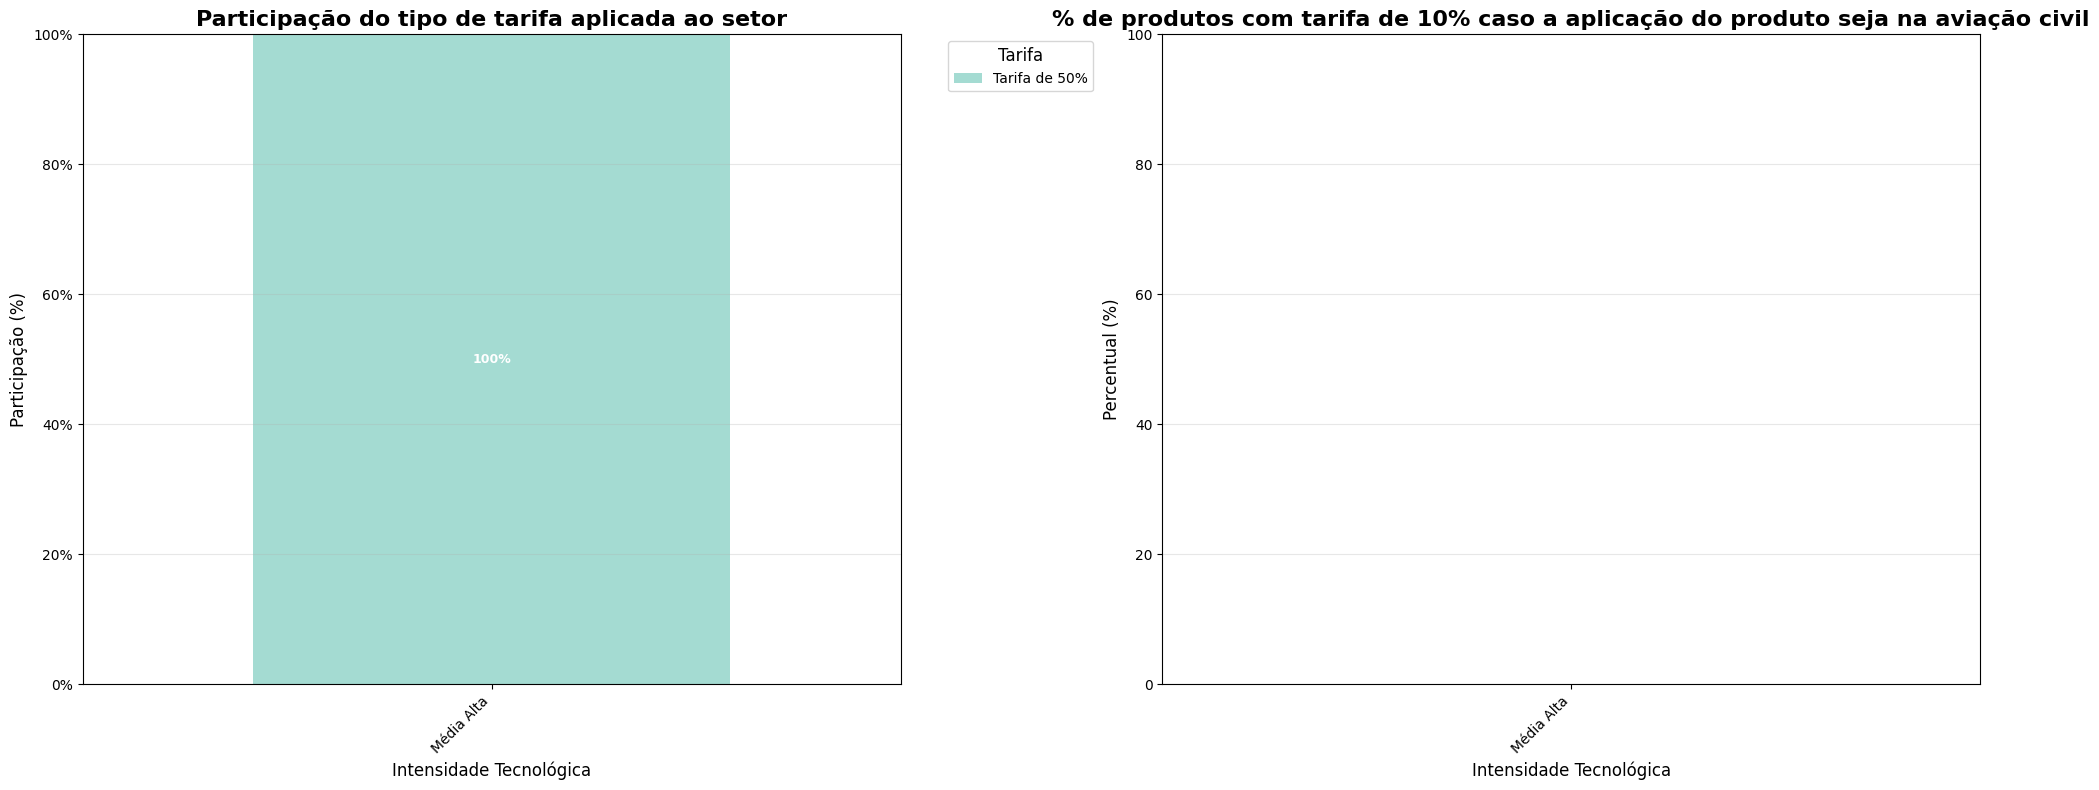

In [ ]:
def analisar_setor_especifico(dataframe, cnae_codigo):
    """
    Análise específica para um setor CNAE
    """
    print(f"=== ANÁLISE DETALHADA DO SETOR CNAE {cnae_codigo} ===")
    
    # Verificar se existe o CNAE
    if cnae_codigo not in dataframe['cnae'].values:
        print(f"CNAE {cnae_codigo} não encontrado no dataframe")
        setores_disponiveis = dataframe['cnae'].unique()[:10]
        print(f"Setores disponíveis (primeiros 10): {setores_disponiveis}")
        return None
    
    # Criar gráfico para o setor específico
    dados_agrupados, dados_pivot = criar_grafico_intensidade_tarifa(dataframe, cnae_codigo)
    
    return dados_agrupados, dados_pivot


In [ ]:

# Exemplo de uso:
# Assumindo que seu dataframe se chama 'exportacao_pia_tarifas'

# Análise geral (todos os setores)
print("=== ANÁLISE GERAL - TODOS OS SETORES ===")
try:
    # Substitua 'exportacao_pia_tarifas' pelo nome real do seu dataframe
    dados_agrupados_geral, pivot_geral = criar_grafico_intensidade_tarifa(exportacoes_pia_tarifas)
except NameError:
    print("Dataframe não encontrado. Certifique-se de que o dataframe existe com o nome correto.")

# Listar setores disponíveis
try:
    setores_disponiveis = exportacoes_pia_tarifas[['cnae', 'cnae_descricao']].drop_duplicates().sort_values('cnae')
    print(f"\n=== SETORES DISPONÍVEIS (primeiros 10) ===")
    print(setores_disponiveis.head(10).to_string(index=False))
    
    # Análise de um setor específico (exemplo)
    cnae_exemplo = setores_disponiveis['cnae'].iloc[0]
    print(f"\n=== ANÁLISE DO SETOR {cnae_exemplo} ===")
    dados_setor, pivot_setor = analisar_setor_especifico(exportacoes_pia_tarifas, cnae_exemplo)
    
except NameError:
    print("Dataframe não encontrado. Verifique o nome do dataframe.")

Setores disponíveis:
     cnae                      cnae_descricao
2614  060  Extração de petróleo e gás natural
2009  071        Extração de minério de ferro

Analisando setor: 060


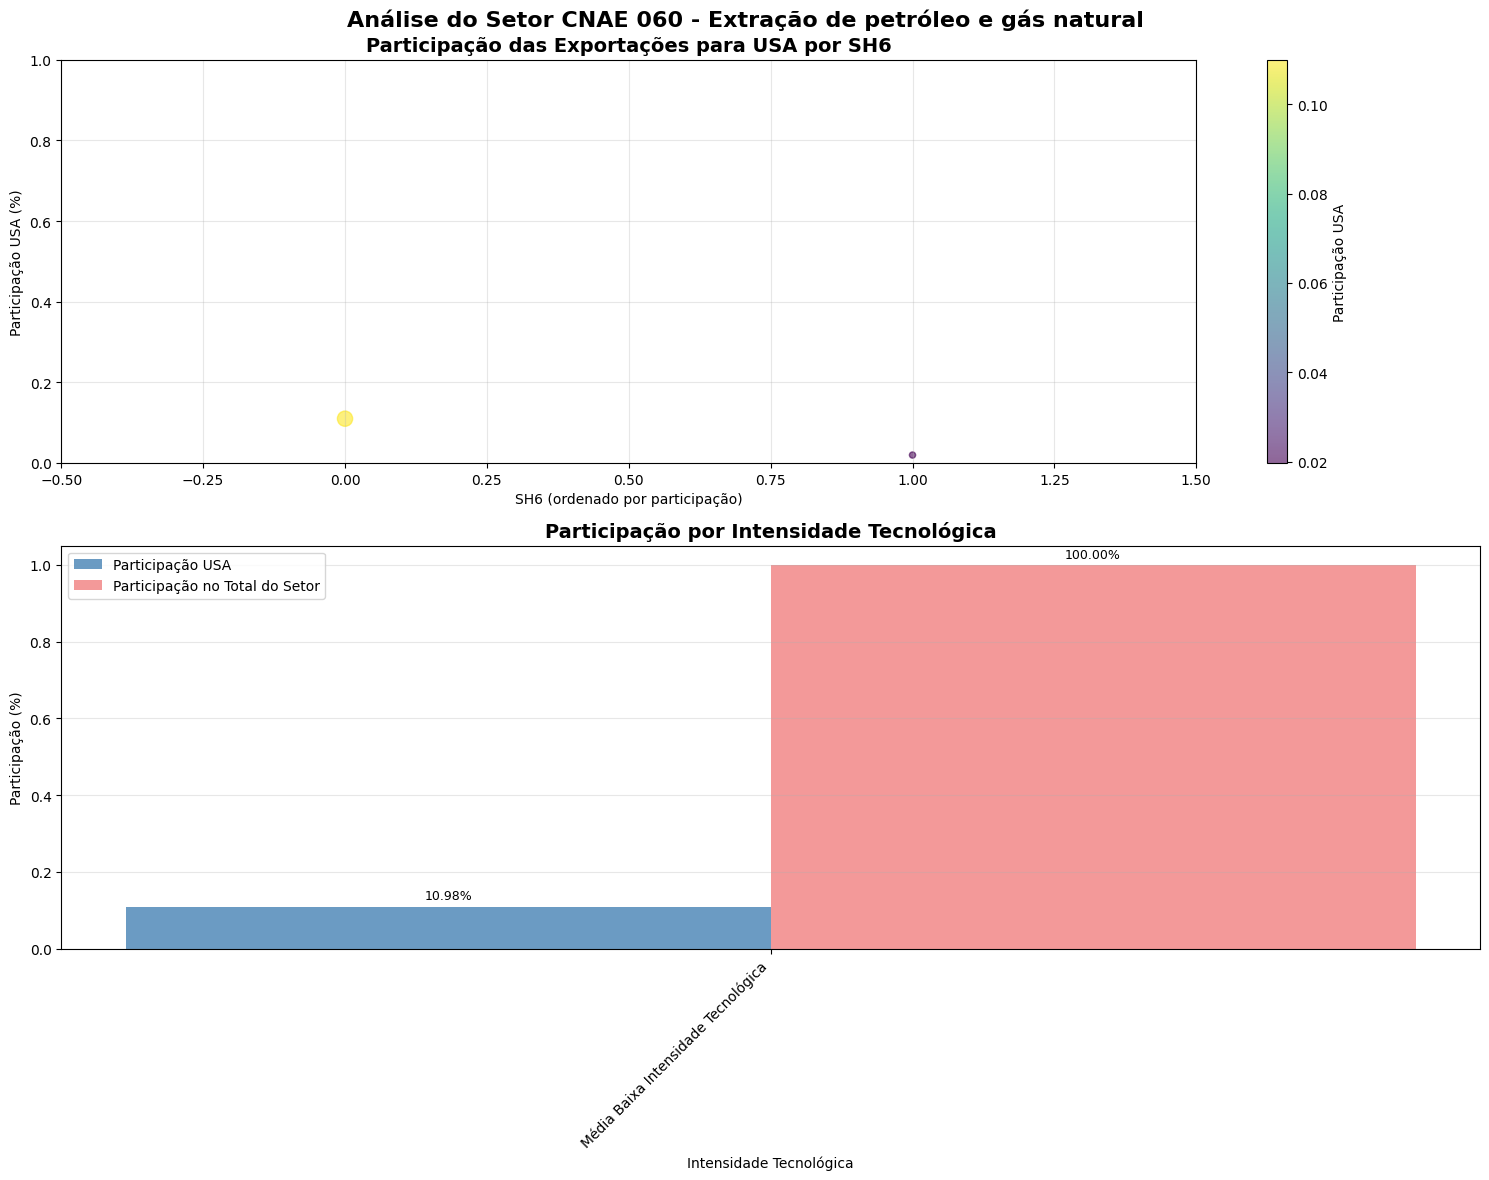


=== Estatísticas do Setor CNAE 060 ===
Descrição: Extração de petróleo e gás natural
Quantidade de SH6s: 2
Exportações Totais para o Mundo: R$ 229,920,398,959
Exportações para USA: R$ 25,251,450,022
Participação USA no setor: 10.98%


In [156]:
# Exemplo de uso:
# Listar setores disponíveis
print("Setores disponíveis:")
setores_disponiveis = exportacoes_pia_tarifas[['cnae', 'cnae_descricao']].drop_duplicates().sort_values('cnae')
print(setores_disponiveis.head(2))

# Selecionar um setor específico (exemplo: primeiro setor disponível)
cnae_exemplo = setores_disponiveis['cnae'].iloc[0]
print(f"\nAnalisando setor: {cnae_exemplo}")

# Criar os gráficos
dados_setor, dados_intensidade = criar_graficos_setor(cnae_exemplo, exportacoes_pia_tarifas)

In [90]:
exportacoes_pia['R$ FOB USA'] = exportacoes_pia['R$ FOB USA'].astype(float)
exportacoes_pia['Total da receita líquida de vendas'] = exportacoes_pia['Total da receita líquida de vendas'].astype(float)

In [120]:
exportacoes_agregadas_cnae = exportacoes_pia.groupby(['cnae','cnae_descricao']).aggregate({'R$ FOB USA': 'sum','Total da receita líquida de vendas' : 'mean' }).reset_index()

In [121]:
exportacoes_agregadas_cnae.head()

,cnae,cnae_descricao,R$ FOB USA,Total da receita líquida de vendas
0,060,Extração de petróleo e gás natural,2.525145e+10,1.632819e+11
1,071,Extração de minério de ferro,2.071770e+09,1.969583e+11
2,072,Extração de minerais metálicos não-ferrosos,3.120151e+07,2.746607e+10
3,081,"Extração de pedra, areia e argila",8.988183e+07,2.500557e+10
4,089,Extração de outros minerais não-metálicos,2.669222e+08,8.940663e+09


In [122]:
exportacoes_agregadas_cnae['participacao_usa'] = exportacoes_agregadas_cnae['R$ FOB USA'] / exportacoes_agregadas_cnae['Total da receita líquida de vendas']

In [124]:
exportacoes_agregadas_cnae.sort_values(by='participacao_usa', ascending=False)

,cnae,cnae_descricao,R$ FOB USA,Total da receita líquida de vendas,participacao_usa
54,304,Fabricação de aeronaves,1.222860e+10,2.113848e+10,5.784995e-01
33,255,"Fabricação de equipamento bélico pesado, armas...",1.734273e+09,3.961277e+09,4.378066e-01
19,161,Desdobramento de madeira,3.889612e+09,1.501246e+10,2.590922e-01
0,060,Extração de petróleo e gás natural,2.525145e+10,1.632819e+11,1.546494e-01
57,321,"Fabricação de artigos de joalheria, bijuteria ...",6.206487e+08,4.194860e+09,1.479546e-01
...,...,...,...,...,...
21,18,Impressão e reprodução de gravações,1.132288e+06,2.286563e+10,4.951921e-05
41,268,"Fabricação de mídias virgens, magnéticas e ópt...",5.432565e+06,-1.000000e+03,-5.432565e+03
40,267,Fabricação de equipamentos e instrumentos ópti...,1.160705e+07,-1.000000e+03,-1.160705e+04
53,303,Fabricação de veículos ferroviários,9.602509e+07,-1.000000e+03,-9.602509e+04


In [118]:
exportacoes_pia.groupby(['cnae','cnae_descricao']).aggregate({'R$ FOB USA': 'sum','Total da receita líquida de vendas' : 'mean' }).reset_index().query('cnae == "060"')

,cnae,cnae_descricao,R$ FOB USA,Total da receita líquida de vendas
0,060,Extração de petróleo e gás natural,2.525145e+10,1.632819e+11
